In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

In [6]:
import numpy as np 

def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


In [7]:
from scipy import signal
def compute_Reliability(spike_matrix,t,t_R):
    '''
    Computes the value of Reliability, a synchrony measurement that computes the variance of a convoluted spike train that is the sum of the spike trains of each neuron.

    Parameters:
        spike_matrix (tuple[tuple[int,int]] | sparse_matrix):
            matrix containing spike trains, each row contains a diffent neuron.
        t (list[float]):
            time array, time points of the simulation
        t_R (float):
            Time constant

    Returns:
        reliability / reliability_max (float):
            The computed value of reliability, normalised so (theorically) is between 0 and 1.
        Convolved_matrix (tuple[float]):
            The convolved spike train.
    '''

    #compute the time step of the simulation
    T = t[-1] - t[0]
    dt = T / len(t)

    #we need to work with a np.ndarray for the convolution, if it is a sparse_matrix, change it to that type
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    #Compute the mean number of spikes
    num_spikes = (spike_matrix>0).sum()/num_neurons

    #Compute the kernel, and convolve the sum spike train with it
    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = 1/ t_R *np.exp(-t / t_R)
    Convolved_matrix = signal.convolve(joined_matrix,kernel)[0:len(spike_matrix[0,:])]
    #Convolved_matrix = joined_matrix

    #compute the measurements of reliability
    reliability = 1 / t[len(t) - 1] * np.trapz(np.square(Convolved_matrix), dx = dt) - np.square( 1 / t[len(t) - 1] * np.trapz(Convolved_matrix,dx =dt))
    reliability_max = ( num_neurons**2 * num_spikes / ( t_R * 2 * T ) - ( num_neurons * num_spikes / T )**2 )
    #reliability_max = 1
    return reliability/reliability_max, Convolved_matrix

In [2]:
# Sim and Basic Parameters
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

Synaptic Conductance: 0.05, Average Firing Rate: 9.07 Hz
Synaptic Conductance: 0.10, Average Firing Rate: 7.60 Hz
Synaptic Conductance: 0.15, Average Firing Rate: 6.50 Hz
Synaptic Conductance: 0.20, Average Firing Rate: 5.50 Hz
Synaptic Conductance: 0.25, Average Firing Rate: 5.38 Hz
Synaptic Conductance: 0.30, Average Firing Rate: 4.82 Hz
Synaptic Conductance: 0.35, Average Firing Rate: 4.35 Hz
Synaptic Conductance: 0.40, Average Firing Rate: 3.93 Hz
Synaptic Conductance: 0.45, Average Firing Rate: 4.03 Hz
Synaptic Conductance: 0.50, Average Firing Rate: 3.97 Hz
Synaptic Conductance: 0.55, Average Firing Rate: 3.72 Hz
Synaptic Conductance: 0.60, Average Firing Rate: 3.50 Hz
Synaptic Conductance: 0.65, Average Firing Rate: 3.55 Hz
Synaptic Conductance: 0.70, Average Firing Rate: 3.53 Hz
Synaptic Conductance: 0.75, Average Firing Rate: 3.50 Hz
Synaptic Conductance: 0.80, Average Firing Rate: 3.35 Hz
Synaptic Conductance: 0.85, Average Firing Rate: 3.42 Hz
Synaptic Conductance: 0.90, Ave

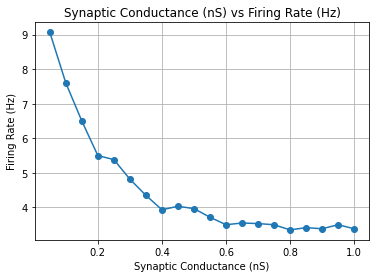

In [3]:
# Firing Rate
connection_strengths = np.linspace(0.05, 1, 20)  
firing_rates = []

# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute average firing rate for this I value
    average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100)) * 1000
    firing_rates.append(average_firing_rate)
    print(f"Synaptic Conductance: {conn_strength:.2f}, Average Firing Rate: {average_firing_rate:.2f} Hz")

# Plotting the results
plt.figure()
plt.plot(connection_strengths, firing_rates, marker='o', linestyle='-')
plt.xlabel('Synaptic Conductance (nS)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Synaptic Conductance (nS) vs Firing Rate (Hz)')
plt.grid(True)
plt.show()

Synaptic Conductance (nS): 0.05, Number of Neurons that Spiked: 175
Synaptic Conductance (nS): 0.10, Number of Neurons that Spiked: 176
Synaptic Conductance (nS): 0.15, Number of Neurons that Spiked: 148
Synaptic Conductance (nS): 0.20, Number of Neurons that Spiked: 189
Synaptic Conductance (nS): 0.25, Number of Neurons that Spiked: 159
Synaptic Conductance (nS): 0.30, Number of Neurons that Spiked: 190
Synaptic Conductance (nS): 0.35, Number of Neurons that Spiked: 189
Synaptic Conductance (nS): 0.40, Number of Neurons that Spiked: 189
Synaptic Conductance (nS): 0.45, Number of Neurons that Spiked: 186
Synaptic Conductance (nS): 0.50, Number of Neurons that Spiked: 174
Synaptic Conductance (nS): 0.55, Number of Neurons that Spiked: 177
Synaptic Conductance (nS): 0.60, Number of Neurons that Spiked: 182
Synaptic Conductance (nS): 0.65, Number of Neurons that Spiked: 171
Synaptic Conductance (nS): 0.70, Number of Neurons that Spiked: 178
Synaptic Conductance (nS): 0.75, Number of Neuro

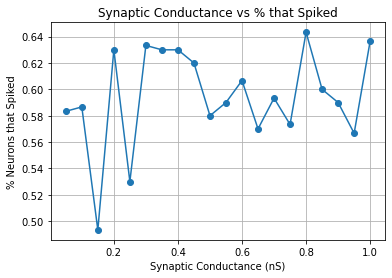

In [4]:
# Fractional Spikes
connection_strengths = np.linspace(0.05, 1, 20)  
no_neurons_spike = []

# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Determine the number of unique neurons that spiked
    spiking_neurons = len(set([neuron for _, neuron in spike_times]))
    no_neurons_spike.append(spiking_neurons)
    print(f"Synaptic Conductance (nS): {conn_strength:.2f}, Number of Neurons that Spiked: {spiking_neurons}")

no_neurons_spike_array = np.array(no_neurons_spike)
fractional_spike = no_neurons_spike_array/N
plt.figure()
plt.plot(connection_strengths, fractional_spike, marker='o', linestyle='-')
plt.xlabel('Synaptic Conductance (nS)')
plt.ylabel('% Neurons that Spiked')
plt.title('Synaptic Conductance vs % that Spiked')
plt.grid(True)
plt.show()

Synaptic Conductance (nS): 0.05, Chi: 0.32861346172141237
Synaptic Conductance (nS): 0.10, Chi: 0.38395235948631007
Synaptic Conductance (nS): 0.15, Chi: 0.3752413989994463
Synaptic Conductance (nS): 0.20, Chi: 0.412015832503042
Synaptic Conductance (nS): 0.25, Chi: 0.40535246704545025
Synaptic Conductance (nS): 0.30, Chi: 0.4066218701068054
Synaptic Conductance (nS): 0.35, Chi: 0.40928737006022553
Synaptic Conductance (nS): 0.40, Chi: 0.24020511330989483
Synaptic Conductance (nS): 0.45, Chi: 0.1703276581263673
Synaptic Conductance (nS): 0.50, Chi: 0.2456194986570665
Synaptic Conductance (nS): 0.55, Chi: 0.28205207696748585
Synaptic Conductance (nS): 0.60, Chi: 0.29259029621232
Synaptic Conductance (nS): 0.65, Chi: 0.19023677791988125
Synaptic Conductance (nS): 0.70, Chi: 0.23824724257867314
Synaptic Conductance (nS): 0.75, Chi: 0.25849031010657353
Synaptic Conductance (nS): 0.80, Chi: 0.29436714825805665
Synaptic Conductance (nS): 0.85, Chi: 0.15916627184035934
Synaptic Conductance (n

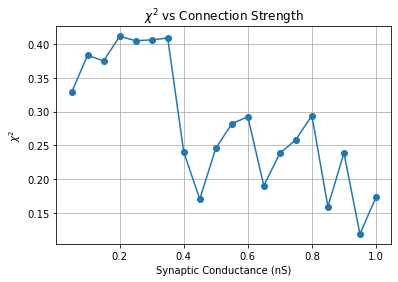

In [8]:
# Chi
connection_strengths = np.linspace(0.05, 1, 20)  # Vary connection strength from 0.25 to 0.5
chi_sq_values = []


# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)
    print(f"Synaptic Conductance (nS): {conn_strength:.2f}, Chi: {chi_sq}")
# Plotting the results
plt.figure()
plt.plot(connection_strengths, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Synaptic Conductance (nS)')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Strength')
plt.grid(True)
plt.show()

Synaptic Conductance (nS): 0.05, Reliability: 4.690956063534771e-15
Synaptic Conductance (nS): 0.10, Reliability: 4.7760728120510074e-15
Synaptic Conductance (nS): 0.15, Reliability: 4.697833598479654e-15
Synaptic Conductance (nS): 0.20, Reliability: 4.68257348035533e-15
Synaptic Conductance (nS): 0.25, Reliability: 4.677917942369547e-15
Synaptic Conductance (nS): 0.30, Reliability: 4.612498375730773e-15
Synaptic Conductance (nS): 0.35, Reliability: 4.534881044752854e-15
Synaptic Conductance (nS): 0.40, Reliability: 4.872768320360086e-15
Synaptic Conductance (nS): 0.45, Reliability: 4.451107813839102e-15
Synaptic Conductance (nS): 0.50, Reliability: 3.939849804947064e-15
Synaptic Conductance (nS): 0.55, Reliability: 4.128064570221378e-15
Synaptic Conductance (nS): 0.60, Reliability: 4.128373451228049e-15
Synaptic Conductance (nS): 0.65, Reliability: 4.421640502691839e-15
Synaptic Conductance (nS): 0.70, Reliability: 4.243404116477102e-15
Synaptic Conductance (nS): 0.75, Reliability: 4.

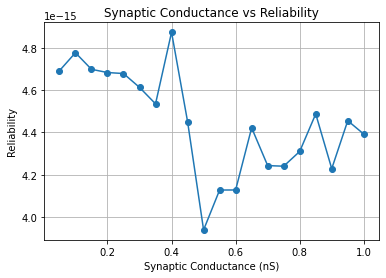

In [10]:
# Reliability
connection_strengths = np.linspace(0.05, 1, 20)  # Vary connection strength from 0.25 to 0.5
reliability_values = []
num_neurons = N
# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    spike_matrix = np.zeros((N, int(T / dt)))
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033  # Avoid division by zero if tauS=0
            
            spike_idx = int(t0 / dt)
            spike_matrix[spike, spike_idx] = 1
            spikeCounter += 1
            i += 1

    # Compute reliability
    reliability, _ = compute_Reliability(spike_matrix, t_all, t_R=29.29)
    reliability_values.append(reliability)
    print(f"Synaptic Conductance (nS): {conn_strength:.2f}, Reliability: {reliability}")

# Plotting the results
plt.figure()
plt.plot(connection_strengths, reliability_values, marker='o', linestyle='-')
plt.xlabel('Synaptic Conductance (nS)')
plt.ylabel('Reliability')
plt.title('Synaptic Conductance vs Reliability')
plt.grid(True)
plt.show()